# Weight of Evidence

WoE = ln(Distribution of Non Events/Distribution of Events)

In [1]:
import pandas as pd
import scorecardpy as sc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from optbinning import OptimalBinning

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

In [2]:
df = pd.read_csv("../data/credit-g_csv.csv")
df.rename(columns={"class":"target"}, inplace=True)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [3]:
df.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
target                    object
dtype: object

In [4]:
df['target'].value_counts()

good    700
bad     300
Name: target, dtype: int64

In [5]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'target'],
      dtype='object')

In [6]:
y = df.target.values
mask = y == "bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

In [7]:
binner = OptimalBinning(name="credit_amount",
                       prebinning_method="uniform",
                       monotonic_trend="ascending")

x = df["credit_amount"].values


binner.fit(x, y)
print(f"Binning Status-{binner.status}")
print(f"Binning splits-{binner.splits}")
binning_table = binner.binning_table
binning_table.build()

Binning Status-OPTIMAL
Binning splits-[ 3884.8  6610.9  9337.  11154.4 13880.5]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 3884.80)",738,0.738,549,189,0.256098,0.219054,0.033797,0.004216
1,"[3884.80, 6610.90)",142,0.142,88,54,0.380282,-0.358945,0.019486,0.002423
2,"[6610.90, 9337.00)",73,0.073,44,29,0.397260,-0.430404,0.014552,0.001805
3,"[9337.00, 11154.40)",19,0.019,11,8,0.421053,-0.528844,0.005792,0.000716
4,"[11154.40, 13880.50)",16,0.016,5,11,0.687500,-1.635755,0.048294,0.005443
5,"[13880.50, inf)",12,0.012,3,9,0.750000,-1.94591,0.050038,0.005424
6,Special,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1000,1.000,700,300,0.300000,,0.171958,0.020026


In [8]:
binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16601429
    IV (Jeffrey)             0.17195770
    JS (Jensen-Shannon)      0.02002580
    Hellinger                0.02070659
    Triangular               0.07564887
    KS                       0.15428571
    HHI                      0.57089800
    HHI (normalized)         0.50959771
    Cramer's V               0.19686978
    Quality score            0.00228281

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     9.187849 0.002436  0.000882  0.999118
        1      2     0.058641 0.808657  0.406688  0.593312
        2      3     0.035496 0.850561  0.431876  0.568124
        3      4     2.484797 0.114951  0.050639  0.949361
        4      5     0.131250 0.717140  0.344559  0.655441



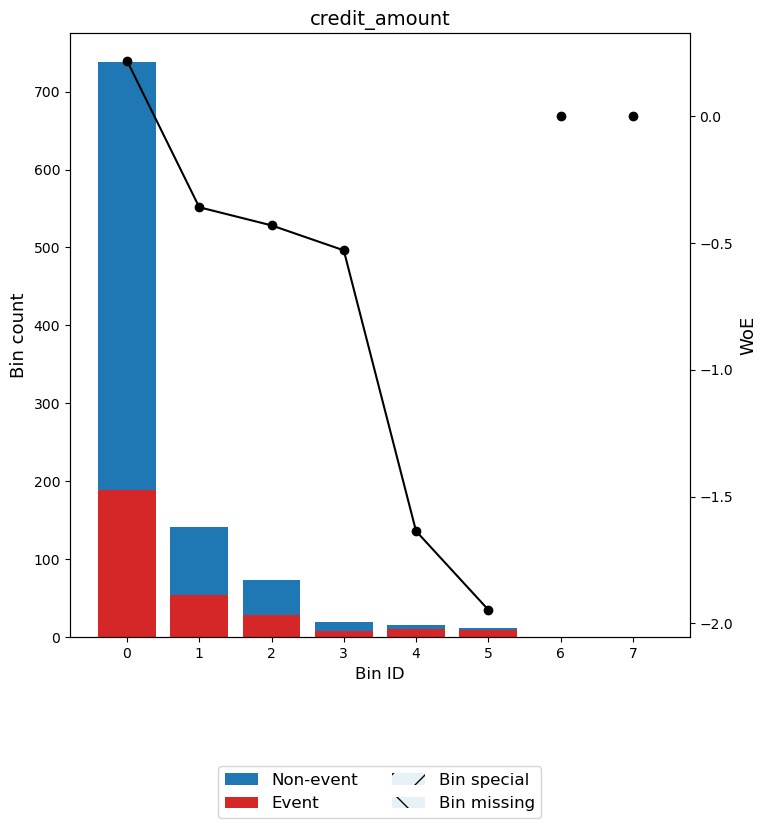

In [9]:
binning_table.plot(metric="woe")

In [10]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

In [11]:
bins = sc.woebin(X_train, y="target")

[INFO] creating woe binning ...


In [12]:
X_train = sc.woebin_ply(X_train,bins)
X_test = sc.woebin_ply(X_test,bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [13]:
bins

{'housing':   variable       bin  count  count_distr  good  bad   badprob       woe  \
 0  housing       own    480     0.716418   358  122  0.254167 -0.214959   
 1  housing      rent    117     0.174627    73   44  0.376068  0.355283   
 2  housing  for free     73     0.108955    40   33  0.452055  0.669181   
 
      bin_iv  total_iv    breaks  is_special_values  
 0  0.031603  0.109232       own              False  
 1  0.023490  0.109232      rent              False  
 2  0.054139  0.109232  for free              False  ,
 'other_payment_plans':               variable            bin  count  count_distr  good  bad  \
 0  other_payment_plans  none%,%stores    577     0.861194   414  163   
 1  other_payment_plans           bank     93     0.138806    57   36   
 
     badprob       woe    bin_iv  total_iv         breaks  is_special_values  
 0  0.282496 -0.070563  0.004226  0.028301  none%,%stores              False  
 1  0.387097  0.402021  0.024075  0.028301           bank       

In [14]:
#Conside the feature "credit_amount"
X_train["target"] = X_train["target"].astype("category")
X_train["target"] = X_train["target"].cat.codes

{'credit_amount': <Figure size 800x800 with 2 Axes>}

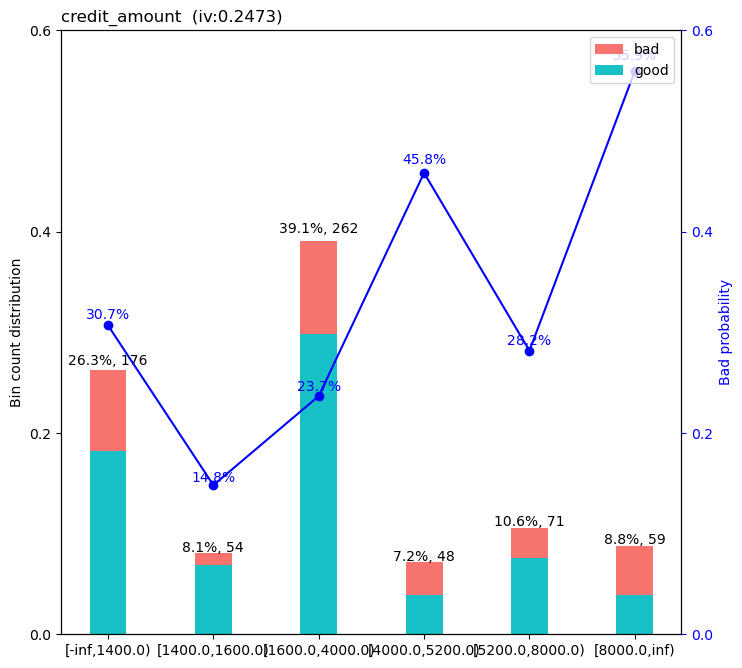

In [15]:
sc.woebin_plot(bins["credit_amount"])

In [17]:
bins["credit_amount"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,credit_amount,"[-inf,1400.0)",176,0.262687,122,54,0.306818,0.046516,0.000574,0.247298,1400.0,False
1,credit_amount,"[1400.0,1600.0)",54,0.080597,46,8,0.148148,-0.887647,0.051007,0.247298,1600.0,False
2,credit_amount,"[1600.0,4000.0)",262,0.391045,200,62,0.236641,-0.309630,0.035010,0.247298,4000.0,False
3,credit_amount,"[4000.0,5200.0)",48,0.071642,26,22,0.458333,0.694499,0.038441,0.247298,5200.0,False
4,credit_amount,"[5200.0,8000.0)",71,0.105970,51,20,0.281690,-0.074540,0.000580,0.247298,8000.0,False
5,credit_amount,"[8000.0,inf)",59,0.088060,26,33,0.559322,1.099964,0.121686,0.247298,inf,False


In [45]:
np.log(X_train["target"].value_counts()[0]/X_train["target"].value_counts()[1])

0.8615532692919254

In [46]:
logitfit = logit(formula = "target ~ credit_amount_woe", \
                 data = X_train).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.582564
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  670
Model:                          Logit   Df Residuals:                      668
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Jul 2021   Pseudo R-squ.:                 0.04233
Time:                        05:00:09   Log-Likelihood:                -390.32
converged:                       True   LL-Null:                       -407.57
Covariance Type:            nonrobust   LLR p-value:                 4.254e-09
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8616      0.087     -9.893      0.000      -1.032      -0.691
credit_amount_woe     1.0000      0.173      5.768      0.000       0.660       1.340
=====================================================================================
"""

In [18]:
#strategy{‘uniform’, ‘quantile’, ‘kmeans’}
discretizer = KBinsDiscretizer(5, encode="ordinal", strategy="kmeans")
discretizer.fit(df[["credit_amount"]])
discretizer.bin_edges_[0].tolist()

[250.0,
 2505.7242629226143,
 5175.952757751596,
 8706.44313262495,
 12784.22619047619,
 18424.0]

In [20]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

[INFO] creating woe binning ...


{'credit_amount': <Figure size 800x800 with 2 Axes>}

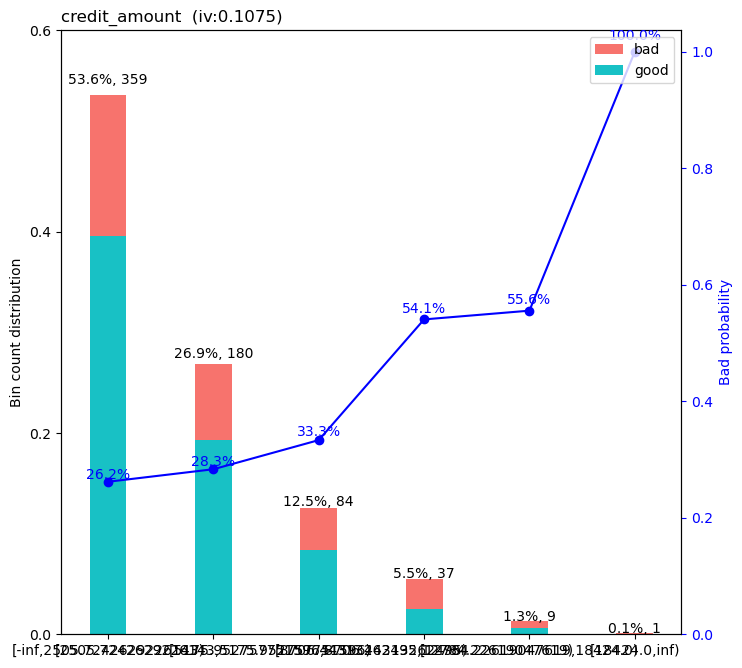

In [21]:


breaks_adj = {
    'credit_amount': discretizer.bin_edges_[0].tolist(),
}

bins = sc.woebin(X_train, y="target",breaks_list=breaks_adj)
sc.woebin_plot(bins["credit_amount"])


In [22]:
bins["credit_amount"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,credit_amount,"[-inf,2505.7242629226143)",359,0.535821,265,94,0.261838,-0.172973,0.015429,0.107549,2505.7242629226143,False
1,credit_amount,"[2505.7242629226143,5175.952757751596)",180,0.268657,129,51,0.283333,-0.064524,0.001102,0.107549,5175.952757751596,False
2,credit_amount,"[5175.952757751596,8706.44313262495)",84,0.125373,56,28,0.333333,0.170315,0.003753,0.107549,8706.44313262495,False
3,credit_amount,"[8706.44313262495,12784.22619047619)",37,0.055224,17,20,0.540541,1.025981,0.066153,0.107549,12784.22619047619,False
4,credit_amount,"[12784.22619047619,18424.0)",9,0.013433,4,5,0.555556,1.086606,0.018091,0.107549,18424.0,False
5,credit_amount,"[18424.0,inf)",1,0.001493,0,1,1.000000,0.968823,0.003021,0.107549,inf,False


In [ ]:
X_train = sc.woebin_ply(X_train,bins)
X_test = sc.woebin_ply(X_test,bins)

X_train["target"] = X_train["target"].astype("category")
X_train["target"] = X_train["target"].cat.codes

In [ ]:
logitfit = logit(formula = "target ~ credit_amount_woe", \
                 data = X_train).fit()
logitfit.summary()

In [ ]:
help(sc.woebin)

### [Reference 1](http://www.m-hikari.com/ams/ams-2014/ams-65-68-2014/zengAMS65-68-2014.pdf)
### [Reference 2](https://www.lexjansen.com/sesug/2014/SD-20.pdf)